https://www.coursera.org/learn/computers-waves-simulations/notebook/pT96d/w5p2-fourier-acoustic-wave-equation-2d

<div style='background-image: url("./title01.png") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 200px'>
<div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
<div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Computers, Waves, Simulations</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">The Pseudo-Spectral Method - Acoustic Waves in 2D</div>
        </div>
    </div>
</div>

This notebook covers the following aspects:
* Present a  Fourier Pseudospectral code for solving the 2D acoustic wave equation
* Compute the same using using finite difference scheme 
* Analyze the disperion behaviour in each case 


## Basic Equations
From article (1) we have 

\begin{equation}
\partial_x \partial_t \alpha = -2 (\partial_t\lambda) (\partial_x\lambda)
\end{equation}
\begin{equation}
\partial_y \partial_t \beta = -2 (\partial_t\lambda) (\partial_y\lambda)
\end{equation}
\begin{equation}
\partial_x \partial_y \gamma = -2(\partial_x\lambda) (\partial_y\lambda)
\end{equation}

The problem of solving the wave equation

\begin{equation}
\partial_t^2 p = c^2 (\partial_{x}^{2}p + \partial_{z}^{2}p) + s
\end{equation}

can be achieved using finite differeces in combination with spectral methods. Here, spatial partial derivatives with respect to $x$ and $z$ are computed via the Fourier method, i.e. 

\begin{equation}
\partial_{x}^{2}p + \partial_{z}^{2}p = \mathscr{F}^{-1}[-k_{x}^{2}\mathscr{F}[p]] + \mathscr{F}^{-1}[-k_{z}^{2}\mathscr{F}[p]]
\end{equation}

where $\mathscr{F}$ represents the Fourier transform operator.

As it was the case in previous numerical solutions, we use a standard 3-point finite-difference operator to approximate the time derivatives. Then, the pressure field is extrapolated as

\begin{equation}
\frac{p_{j,k}^{n+1} - 2p_{j,k}^{n} + p_{j,k}^{n-1}}{dt^2}= c_{j,k}^{2} (\partial_{x}^{2}p + \partial_{z}^{2}p)_{j,k} + s_{j,k}^{n}
\end{equation}

In [1]:
# Import all necessary libraries, this is a configuration step for the exercise.
# Please run it before the simulation code!
import numpy as np
from scipy import signal, fftpack
import matplotlib
# Show Plot in The Notebook
#matplotlib.use("nbagg")
import matplotlib.pyplot as plt

%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D
from ricker import ricker
import pyfftw

import time,datetime

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.animation as animation
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import os
datadir = "data"
if not os.path.exists(datadir): os.makedirs(datadir)

## 1. Fourier derivative method  

In [2]:
def plot3d(x,y,z, fig=None):
    fig = plt.figure()
    ax = plt.axes(projection="3d")
    xx, yy = np.meshgrid(x, y)
    #ax.plot_wireframe(xx, yy, z, color='blue')
    ax.plot_surface(xx, yy, z, color='blue')
    
    ax.set_xlabel('y')
    ax.set_ylabel('x')
    ax.set_zlabel('z')
    
    #plt.draw()
    plt.show()
    return ax

def getfft(dat,dim):
    fft = np.fft.fft2(dat)
    #return fft
    fft[:,int(dim/3):int(2*dim/3)] = 0
    fft[int(dim/3):int(2*dim/3),:] = 0
    return fft

def plotfft(fft, dim, axs=1):
    if len(fft)!=dim: print("dim is not right")
    a = np.abs(np.fft.fftshift(fft))

    mind = int(dim/2)
    r = np.zeros(mind)

    for i in range(1,mind+1):
        sm = 0
        count = 0
        for j in range(mind-i,mind+i):
            count += 2
            #print(mind-i,j)
            sm += (a[mind-i,j])
            #print(mind+i,j)
            sm += (a[mind+i-1,j])

        for k in range(mind-i+1,mind+i-1):
            count += 2
            #print(mind-i+1,k)
            sm += (a[k,mind-i])
            #print(mind+i-1,k)
            sm += (a[k,mind+i-1])
        r[i-1] = sm/count

    #plt.semilogy(r)
    plt.figure()
    plt.loglog(r)
    plt.show()

In [3]:
colors = ['b','r','c','g','m','y','k']
def pltupdate(fig,ax,dats,tp="loglog"):
    if ax.lines:
        for i, line in enumerate(ax.lines):
            if i>=len(dats): break
            if type(dats[i])!=int or dats[i]!=0:
                if type(dats[i])==tuple:
                    line.set_xdata(dats[i][0])
                    line.set_ydata(dats[i][1])
                else:
                    line.set_ydata(dats[i])

        for j in range(i+1,len(dats)):
            if type(dats[j])!=int or dats[j]!=0:
                color = colors[j%len(colors)] #'b' if j>=len(colors) else colors[j]
                if type(dats[j])==tuple:
                    if tp=="loglog":
                        ax.loglog(dats[j][0],dats[j][1], color)
                    elif tp=="plot":
                        ax.plot(dats[j][0],dats[j][1], color)
                else:
                    if tp=="loglog":
                        ax.loglog(dats[j], color)
                    elif tp=="plot":
                        ax.plot(dats[j], color)
            else:
                print("there are some plots missing ({}), but it'll be skiped".format(j))
    else:
        for i, dat in enumerate(dats):
            if type(dat)!=int or dat!=0:
                color = colors[i%len(colors)] #'b' if i>=len(colors) else colors[i]
                if type(dat)==tuple:
                    if tp=="loglog":
                        ax.loglog(dat[0],dat[1], color)
                    elif tp=="plot":
                        ax.plot(dat[0],dat[1], color)
                else:
                    if tp=="loglog":
                        ax.loglog(dat, color)
                    elif tp=="plot":
                        ax.plot(dat, color)
            else:
                print("there are some plots missing ({}), but it'll be skiped".format(i)) 
    fig.canvas.draw()

In [4]:
class fun:
    def __init__(self, dimx, dimy, Lx=1, Ly=1):
        self.dimx = dimx; self.dimy = dimy
        
        self.d = np.zeros((dimx, dimy), dtype=float)
        self.do = np.zeros((dimx, dimy), dtype=float)
        
        self.ddx = np.zeros((dimx, dimy), dtype= float)
        self.ddy = np.zeros((dimx, dimy), dtype= float)
        
        self.ddx2 = np.zeros((dimx, dimy), dtype= float)
        self.ddy2 = np.zeros((dimx, dimy), dtype= float)
        
        self.ddxo = np.zeros((dimx, dimy), dtype= float)
        self.ddyo = np.zeros((dimx, dimy), dtype= float)
        
        self.ddx2o = np.zeros((dimx, dimy), dtype= float)
        self.ddy2o = np.zeros((dimx, dimy), dtype= float)
        
        self.fft = np.zeros((dimx, dimy), dtype= complex)
        self.ffto = np.zeros((dimx, dimy), dtype= complex)
        
        
        self.ddxCalculated = False
        self.ddyCalculated = False
        self.ddx2Calculated = False
        self.ddy2Calculated = False
        self.ddxoCalculated = False
        self.ddyoCalculated = False
        self.ddxo2Calculated = False
        self.ddyo2Calculated = False
        
        
        self.dx = Lx / (dimx-1)
        self.kx = np.fft.fftfreq(dimx,self.dx)*2*np.pi
        
        self.dy = Ly / (dimy-1)
        self.ky = np.fft.fftfreq(dimy,self.dy)*2*np.pi
        
        self.x = np.arange(0, dimx)*self.dx #initialize space coordinates
        self.y = np.arange(0, dimy)*self.dy 
        
    def getk(self):
        return (np.zeros(self.dimx, dtype=complex), np.zeros(self.dimy, dtype=complex))
        
    def derx(self, n=1, plot=False, mode='a'): #mode: 'a'=actual, 'o'=old
        if mode=='a' and self.ddxCalculated and n==1:
            if plot: self.plot(self.ddx)
            return self.ddx
    
        if mode=='a' and self.ddx2Calculated and n==2:
            if plot: self.plot(self.ddx2)
            return self.ddx2
        
        if mode=='o' and self.ddxoCalculated and n==1:
            if plot: self.plot(self.ddxo)
            return self.ddxo
        
        if mode=='o' and self.ddxo2Calculated and n==2:
            if plot: self.plot(self.ddxo2)
            return self.ddxo2
        
        
        kx = np.copy(self.kx)
        kx[1:] = (kx[1:])**(n)
        kx[0]=0
        
        if mode=='a':
            ff = self.fft*(((1j)**n)*(kx[:,np.newaxis]))
        elif mode=='o':
            ff = self.ffto*(((1j)**n)*(kx[:,np.newaxis]))
        else:
            return 0
            
        a = np.real(np.fft.ifft2(ff))
    
        if mode=='a' and n==1:
            self.ddx = a
            self.ddxCalculated = True
        
        if mode=='a' and n==2:
            self.ddx2 = a
            self.ddx2Calculated = True
        
        if plot: self.plot(a)
        return a
    
    
    def dery(self, n=1, plot=False,mode="a"):#mode: 'a'=actual, 'o'=old
        if mode=='a' and self.ddyCalculated and n==1:
            if plot: self.plot(self.ddy)
            return self.ddy
        
        if mode=='a' and self.ddy2Calculated and n==2:
            if plot: self.plot(self.ddy2)
            return self.ddy2
        
        if mode=='o' and self.ddyoCalculated and n==1:
            if plot: self.plot(self.ddyo)
            return self.ddyo
        
        if mode=='o' and self.ddyo2Calculated and n==2:
            if plot: self.plot(self.ddyo2)
            return self.ddyo2
        
        ky = np.copy(self.ky)
        ky[1:] = (ky[1:])**(n)
        ky[0]=0
        
        if mode=='a':
            ff = self.fft*(((1j)**n)*(ky))
        elif mode=='o':
            ff = self.ffto*(((1j)**n)*(ky))
        
        a = np.real(np.fft.ifft2(ff))
        
        if mode=='a' and n==1: 
            self.ddy = a
            self.ddyCalculated = True
        
        if mode=='a' and n==2: 
            self.ddy2 = a
            self.ddy2Calculated = True
        
        if plot: self.plot(a)
        return a
    
    
    def upd(self, newf, plot=False,forcage = None, forcage_fft=None,forcage_mode='add_fft'):
        self.do = self.d
        if type(forcage)!=type(None) and forcage_mode=='multiply':
            self.d = newf*(1+forcage)
        else:
            self.d = newf
        
        self.ddxoCalculated = self.ddxCalculated
        if self.ddxCalculated:
            self.ddxo = self.ddx
        
        self.ddxo2Calculated = self.ddx2Calculated
        if self.ddx2Calculated:
            self.ddxo2 = self.ddx2
            
        self.ddyoCalculated = self.ddyCalculated
        if self.ddyCalculated:
            self.ddyo = self.ddy
            
        self.ddyo2Calculated = self.ddy2Calculated
        if self.ddy2Calculated:
            self.ddyo2 = self.ddy2
    
        self.ffto = self.fft
        
        self.fft = np.fft.fft2(self.d)
        self.fft[:,int(self.dimy/3):int(2*self.dimy/3)] = 0
        self.fft[int(self.dimx/3):int(2*self.dimx/3),:] = 0
        
        if type(forcage)!=type(None) and type(forcage_fft)!=type(None) and forcage_mode=='add_fft':
            self.fft += forcage*forcage_fft
            self.d = np.real(np.fft.ifft2(self.fft))
            
        
        self.ddxCalculated = False
        self.ddx2Calculated = False
        self.ddyCalculated = False
        self.ddy2Calculated = False
        
        if plot: self.plot()
        
    def setByFourier(self, kx, ky, Ampl=1, plot=False):
        if len(kx)!=self.dimx or len(ky)!=self.dimy:
            print("not right length for SetByFourier")
        
        k=np.zeros((self.dimx, self.dimy),dtype=complex)

        for i in range(int(2*self.dimx/3)):
            for j in range(int(2*self.dimy/3)):
                k[i][j]=kx[i]*ky[j]

                
        a=np.real(np.fft.ifft2(k))
        self.upd(a, plot=plot)
        
        return a
    
    def getfft(self,plot=False,d2=False,axs=1):
        if plot: 
            if not d2:
                self.plot(np.abs(self.fft),x=self.kx, y=self.ky)
            else:
                plt.figure()
                a = np.abs((self.fft)).sum(axis=axs)/(self.dimy if axs else self.dimx)
                plt.semilogy(a[:int(len(a)/2)])
                plt.show()
            return
        else:
            return self.fft
    
    def plot(self,whatToPlot=None,x=None,y=None):
        if type(x)==type(None): x = self.x
        if type(y)==type(None): y = self.y
            
        if type(whatToPlot)==type(None):
            return plot3d(x, y, self.d)
        else:
            return plot3d(x, y, whatToPlot)
        

In [5]:
def calculateDer(dat, dimx, dx, direc='x', n=1, plot=False,fft=None,retfft=False):
    if type(fft)==type(None):
        fft = np.fft.fft2(dat)
        fft[:,int(dimx/3):int(2*dimx/3)] = 0
        fft[int(dimx/3):int(2*dimx/3),:] = 0
    
    kx = np.fft.fftfreq(dimx,dx)*2*np.pi
    kx[1:] = (kx[1:])**(n)
    kx[0]=0
    
    if direc=='x':
        ff = fft*(((1j)**n)*(kx[:,np.newaxis]))
    else:
        ff = fft*(((1j)**n)*(kx))
    
    a = np.real(np.fft.ifft2(ff))
    
    if(plot):
        x  = np.arange(0, dimx)*dx
        plot3d(x, x, a)
    
    if retfft:
        return a, ff
    
    return a


In [6]:
def energyk(l,L,dx):
    dim = len(l)
    lk = np.fft.fftshift(getfft(dat=l,dim=dim))
    Lk = np.fft.fftshift(getfft(dat=L,dim=dim))
    kx = np.fft.fftshift(np.fft.fftfreq(dim,dx)*2*np.pi)
    kx = np.repeat([kx],dim,axis=0)**2
    kx = np.sqrt(np.transpose(kx)+kx)
    
    kxd = np.zeros([dim,dim])
    kx[int(dim/2),int(dim/2)] = 1
    kxd = kx**(-1)
    kx[int(dim/2),int(dim/2)] = 0
    kxd[int(dim/2),int(dim/2)] = 0

    ak = np.zeros(dim,dtype=complex)
    ak = np.sqrt(kx)*lk/np.sqrt(2) + 1j*np.sqrt(kxd)*Lk/np.sqrt(2)
    return kx/(2*np.pi),ak

def energy(l,L,dx):
    k,ak = energyk(l,L,dx)
    return np.sum(k*np.abs(ak)**2)

def hatmodule(ld,Ld,ddx):
    k, eng = energyk(l=ld,L=Ld,dx=ddx)
    hat = np.zeros((int(np.ceil(np.max(np.abs(k))))+1,2))
    for i in range(len(eng)):
        for j in range(len(eng[i])):
            y = int(np.ceil(np.abs(k[i][j])))
            hat[y][0]+=1
            hat[y][1]+=k[i][j]*(np.abs(eng[i][j])**2)
    #print(hat)
    for i in range(len(hat)):
        if hat[i][0]!=0:
            hat[i][1]=hat[i][1]/hat[i][0]
    return hat[:int(len(ld)/3),1]

In [7]:
class stack:
    def __init__(self, size=5):
        self.arr = np.zeros(size)
        self.size = size
        self.sum = 0
        self.i = 0
    def push(self, a):
        self.i = (self.i+1)%self.size
        self.sum += -self.arr[self.i] + a
        self.arr[self.i] = a
        return self.sum
    def pop(self):
        return self.arr[self.i]
    def print(self):
        print(self.arr, self.i)

class stackdif:
    def __init__(self, size=5):
        self.stack1 = stack(size)
        self.stack2 = stack(size)
        self.sum1 = self.stack1.sum
        self.sum2 = self.stack1.sum
        self.size = size
        self.j = 0
        self.full = False
        
    def push(self, a):
        self.j+=1
        if self.j>self.size*2: self.full = True 
        self.sum2 = self.stack2.push(self.stack1.pop())
        self.sum1 = self.stack1.push(a)
    
    def dif(self):
        if not self.full or self.sum2==0: return 0
        return (self.sum1-self.sum2)/self.sum2
    
    def print(self):
        self.stack1.print()
        self.stack2.print()

# Test

## 2. Initialization of setup

# First Solution 

In [8]:
nx = 64
l = fun(nx,nx)
L = fun(nx,nx)

In [9]:
kx, ky = l.getk()
rnd = np.random.random(size = 3*nx)
for i in range(0,len(kx)):
    kx[i] = 5*10**-2*np.exp(1j*2*np.pi*rnd[i])
    ky[i] = 5*10**-2*np.exp(1j*2*np.pi*rnd[len(kx) + i])
    
for i in range(int(nx/10),int(nx/6)):
    kx[i] = 5*10**0*np.exp(1j*2*np.pi*rnd[i])
    ky[i] = 5*10**0*np.exp(1j*2*np.pi*rnd[len(kx) + i])

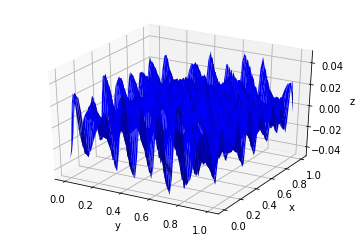

In [10]:
l.setByFourier(kx,ky,plot=True);

In [11]:
forcage_curve = l.fft #5*10**-4

In [13]:
res = []
name = "res_0"

time = 200 #*(10**0)
dt = 5*10**-5
#time = 2000*dt

startime=0
starti = 0
time_pass = 0
time_rest = 0

nt = int(time/dt)
savet = int(.5/dt)#int(nt*0.05) if nt>20 else 1 #int(.05/dt)
plott = int(nt*0.1) if nt>10 else 1
checkt = int(.01/dt) #int(nt*0.001) if nt>1000 else 1

l0 = l
eng = 0
engz = 0

L = fun(nx,nx)
a = fun(nx,nx)
A = fun(nx,nx)
b = fun(nx,nx)
B = fun(nx,nx)
g = fun(nx,nx)
G = fun(nx,nx)

nua = 2*.000001
nub = 2*.000001
nug = 2*.000001
nul = 2*.000001

res0 = (0,l.d.copy(),L.d.copy(),0)
hatmodule0 = hatmodule(res0[1],res0[2],l.dx)

line23 = (np.linspace(1,l.dimx,l.dimx)[:int(l.dimx/3)])**(-2/3)
q = np.argmax(hatmodule0)
line23 =line23/line23[q]*hatmodule0[q]

forcage = 0
forcage_coef = 10**-5
forcage_sign = 0
forcage_signi = 0

if not os.path.exists(datadir+"\\"+name): os.makedirs(datadir+"\\"+name)
for i in range(len(os.listdir("./"))+1):
    if not os.path.isfile('{}\\{}\\{}_{}.npy'.format(datadir,name,name,i)): break
if i>1 and 0:
    try:
        res0 = (np.load('{}\\{}\\{}_{}.npy'.format(datadir,name,name,i-1)))
        startime = res0[0]
        starti = i
        l.upd(res0[1])
        L.upd(res0[2])
        forcage = res0[4]
        forcage_coef = res0[5]
        print("will start calculation from t={} (i={})".format(res0[0],i-1))
    except Exception as e:
        print(e)
else:
    print("start new calculation")

start new calculation


time=500.000; nt=10000000; savet = 0.5000; plott = 50.0000; checkt= 0.0100


<IPython.core.display.Javascript object>


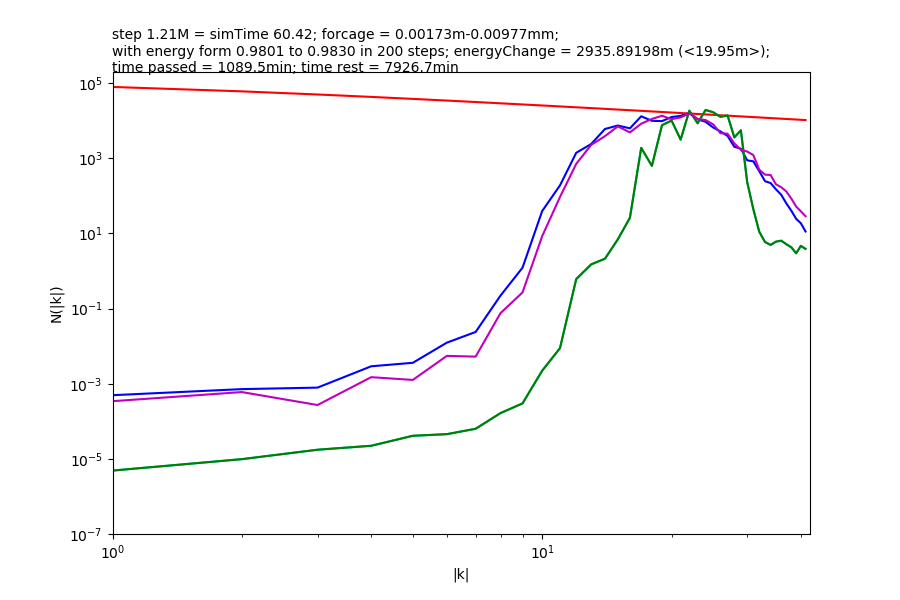

<IPython.core.display.Javascript object>


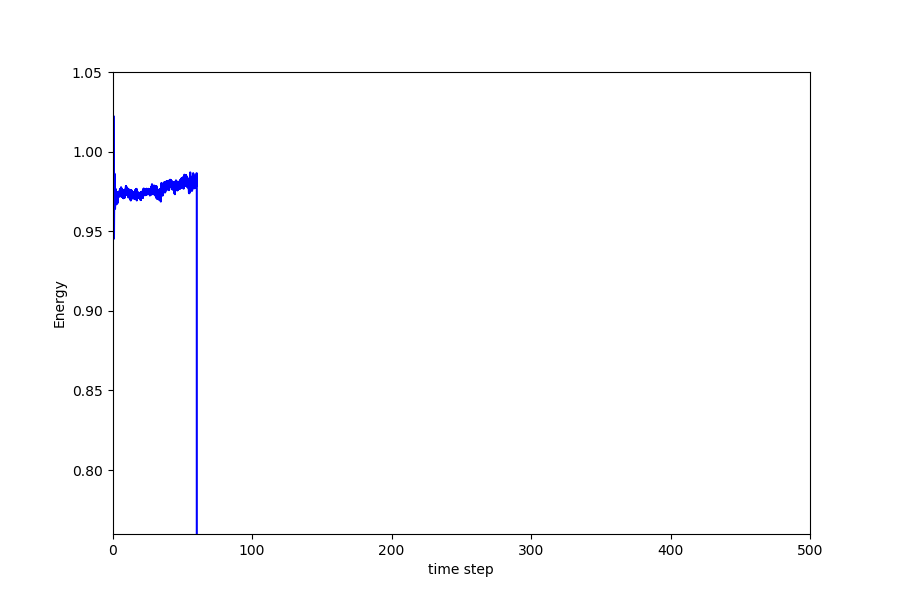

In [ ]:
%matplotlib notebook
# Time extrapolation
# ---------------------------------------------------------------

sdif = stackdif(25)

print("time={:.3f}; nt={:.0f}; savet = {:.4f}; plott = {:.4f}; checkt= {:.4f}".format(nt*dt, nt, savet*dt,plott*dt,checkt*dt))
#res.append((0,l.d.copy(),L.d.copy(),0))
fig,ax = plt.subplots(1,1)
plt.xlim(1,int(l.dimx/3))
ylim = (10**-7,10**5)
plt.ylim(ylim)
plt.xlabel("|k|")
plt.ylabel("N(|k|)")
fig.set_size_inches((9,6))
txt = plt.text(1,2*10**5,"")

pltupdate(fig,ax,[hatmodule0,line23,hatmodule0])
toplot = [0,0,0]

fig2,ax2 = plt.subplots(1,1)
ylim2 = (0.95,1.05)
plt.ylim(ylim2)
plt.xlim(0,nt*dt)
plt.ylabel("Energy")
plt.xlabel("time step")
fig2.set_size_inches((9,6))

toplot2 = [([j*checkt*dt for j in range(int(nt/checkt)+1)], np.zeros(int(nt/checkt)+1))]

start = datetime.datetime.now()


for it in range(nt):
    # 1) l'=L
    if forcage!=None:
        lf = ((3./2.*L.d - 1./2.*L.do)*dt + l.d)
    else:
        lf = ((3./2.*L.d - 1./2.*L.do)*dt + l.d)
        
    
    
    # 2) dxy(g) = -2(dx l)(dy l)
    gf = -2*l.derx()*l.dery()
    gf, gfft = calculateDer(gf,g.dimx,g.dx,direc='x',n=-1,retfft=True)
    gf, gfft = calculateDer(gf,g.dimy,g.dy,direc='y',n=-1,retfft=True,fft=gfft)
    
    # 3) g'=G + nug*(l,xx+l,yy)
    
    Gf = (2.*((gf-g.d)/dt - nug*(calculateDer(gf,g.dimx,g.dx,direc='x',n=2,fft=gfft) + calculateDer(gf,g.dimy,g.dy,direc='y',n=2,fft=gfft))/2. +
               - nug*(g.derx(n=2)+g.dery(n=2))/2.) + G.d)/3 #
    
    # 4) L' = ...    
    Lf = (3*((1+a.d-b.d+g.d)*l.derx(n=2) + (1-a.d+b.d+g.d)*l.dery(n=2) + 
          (a.derx()-b.derx()+g.derx())*l.derx()+(-a.dery()+b.dery()+g.dery())*l.dery()
          - (A.d+B.d-G.d)*L.d)*((1-(a.d+b.d-g.d)+((a.d+b.d-g.d)**2))**(1))/2 - 
          ((1+a.do-b.do+g.do)*l.derx(n=2,mode='o') + 
           (1-a.do+b.do+g.do)*l.dery(n=2,mode='o') + 
          (a.derx(mode='o') - b.derx(mode='o') + g.derx(mode='o')) * l.derx(mode='o') + 
          (-a.dery(mode='o')+ b.dery(mode='o') + g.dery(mode='o')) * l.dery(mode='o') - 
          (A.do+B.do-G.do)*L.do)*((1-(a.do+b.do-g.do)+((a.do+b.do-g.do)**2))**(1))/2
         )*dt + L.d + nul*(L.derx(n=2)+L.dery(n=2))*dt #
    
    #((1+a.d+b.d-g.do)**(-1))
    
    l.upd(lf,forcage=forcage,forcage_fft=forcage_curve,forcage_mode='multiply')
    g.upd(gf)
    G.upd(Gf)
    
    # 5)
    Af = Lf*l.derx()
    Af = -2*calculateDer(Af, l.dimx, l.dx, direc='x', n=-1)
    
    
    # 6)
    Bf = Lf*l.dery()
    Bf = -2*calculateDer(Bf, l.dimy, l.dy, direc='y', n=-1)
    
    # 7)
    af = (3.*Af/2 - A.d/2. + nua*(a.derx(n=2)+a.dery(n=2)))*dt + a.d #
    
    # 8)
    bf = (3.*Bf/2 - B.d/2. + nub*(b.derx(n=2)+b.dery(n=2)))*dt + b.d #
    
#    l.upd(lf)
    L.upd(Lf)
    a.upd(af)
    A.upd(Af)
    b.upd(bf)
    B.upd(Bf)
            
      
    if it%checkt==0:
        eng1 = energy(l=l.d,L=L.d,dx=l.dx)
        sdif.push(eng1)
        if engz==0: 
            engz = eng1
        elif forcage!=None:
            if sdif.full and sdif.dif() < -10**-6:
                #if forcage_sign!=1:
                #    forcage_sign = 1
                forcage_signi+=1
                if forcage_signi>1:
                    forcage += forcage_coef
                if forcage_signi>3:
                    forcage_signi = 0
                    if forcage_sign!=1:
                        forcage_sign = 1 
                        if forcage_coef>10**-8: forcage_coef /= 2
                
            if sdif.full and sdif.dif() > 10**-6:
                #if forcage_sign!=-1:
                #    forcage_sign = -1
                forcage_signi-=1
                if forcage_signi<-1:
                    forcage -= forcage_coef
                if forcage_signi<-3:
                    forcage_signi = 0
                    if forcage_sign!=-1:
                        forcage_sign = -1
                        if forcage_coef>10**-8: forcage_coef /= 2
                
        
        #if len(res)>=1:
        if len(toplot): 
            try:
                toplot[0] = hatmodule(l.d.copy(),L.d.copy(),l.dx)
                pltupdate(fig,ax,toplot)
            except Exception as e:
                print(e)

        if (eng!=0 and (eng1-eng)/eng1>2) or eng1==np.nan or np.isnan(eng):
            #res.append((it*dt,l.d.copy(),L.d.copy()))
            print("converge (energy goes form {:.4f} to {:.4f})".format(eng/engz,eng1/engz))
            break;
        engold = eng
        eng=eng1
        
        q = eng/engz
        
        #print(toplot2[0][0][int(it/checkt)], toplot2[0][1][int(it/checkt)])
        try:
            toplot2[0][1][int(it/checkt)]=q
            if q<ylim2[0]: 
                ylim2 = (q*0.8,ylim2[1])
                ax2.set_ylim(ylim2)
            if q>ylim2[1]: 
                ylim2 = (ylim2[0],q*1.2)
                ax2.set_ylim(ylim2) 
            pltupdate(fig2,ax2,toplot2,"plot")
        except Exception as e:
            print(e)
        
        time_pass = (datetime.datetime.now() - start).total_seconds()
        time_rest = 0 if it==0 else time_pass/it*(nt-it)
        sign = "+" if forcage_sign>0 else "-"
        
        try:
            txt.set_text("step {:.2f}M = simTime {:.2f}; forcage = {:.5f}m{}{:.5f}mm; \nwith energy form {:.4f} to {:.4f} in {:.0f} steps; energyChange = {:.5f}m (<{:.2f}m>); \ntime passed = {:.1f}min; time rest = {:.1f}min".format(
            it/(10**6),it*dt,forcage*10**3,sign,forcage_coef*10**6,engold/engz,q,checkt,(eng1-engold)/eng1*10**6,sdif.dif()*10**6,time_pass/60,time_rest/60))
        except Exception as e:
            print("text",e)
            
    if it%savet==0:
        if engz==0: engz = eng1
        #res.append((it*dt,l.d.copy(),L.d.copy(),eng))
        res0 = (startime + it*dt,l.d.copy(),L.d.copy(),eng, forcage, forcage_coef)
        x = np.asarray(list(res0),dtype=object)
        np.save('{}\\{}\\{}_{}.npy'.format(datadir,name,name,int(starti + it/savet)),x)
        
        #time_pass = (datetime.datetime.now() - start).total_seconds()
        #time_rest = 0 if it==0 else time_pass/it*(nt-it)
        
        #txt.set_text("step {:.2f}mill = simTime {:.2f}; forcage = {:.5f}+-{:.5f}; energyChange = {:.5f} \nwith energy form {:.4f} to {:.4f} in {:.0f} steps; \ntime passed = {:.1f}min; time rest = {:.1f}min".format(
        #    it/(10**6),it*dt,forcage,forcage_coef,(eng1-engold)/eng1,engold/engz,eng/engz,savet,time_pass/60,time_rest/60))
        
        
        #print("step {:.2f}mill = simTime {:.3f}; with energy form {:.4f} to {:.4f} in {:.0f} steps; time passed = {:.1f}min; time rest = {:.1f}min".format(
        #    it/(10**6),it*dt,engold/engz,eng/engz,savet,time_pass/60,time_rest/60))
        #hatmodule1 = hatmodule(res[-1][1],res[-1][2],l.dx)
        
        
    try:
        if it%plott==0: # and len(res)>=2:
            #hatmodule1 = 
            toplot.append(hatmodule(res0[1],res0[2],l.dx))

            line23 = (np.linspace(1,l.dimx,l.dimx)[:int(l.dimx/3)])**(-2/3)
            q = np.argmax(toplot[-1])
            line23 =line23/line23[q]*toplot[-1][q]
            toplot[1] = line23
            if line23[0] > ylim[1]: 
                ylim=(ylim[0],line23[0]*1.2)
                ax.set_ylim(ylim)
            pltupdate(fig,ax,toplot)

            toplot[-1] = 0
    except Exception as e:
        print(e)
    
    
    #if not it % int(nt/100):                    
    #    # Display Solution
    #    # -------------------------------------- 
    #    res.append((it*dt,sp))
    #    print("{} = {}".format(it,it*dt))
    
print("End. total time {:.3f}".format((datetime.datetime.now() - start).total_seconds()))


# Data analysis 

In [10]:
nx = 64
l = fun(nx,nx)
L = fun(nx,nx)
time = 200 #*(10**0)
dt = 5*10**-5
nt = int(time/dt)

<IPython.core.display.Javascript object>


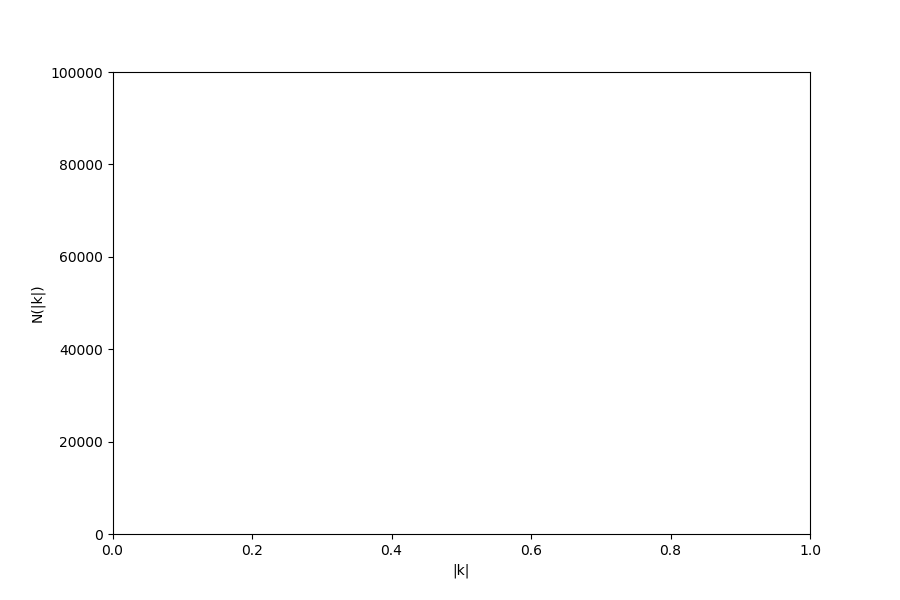

<IPython.core.display.Javascript object>


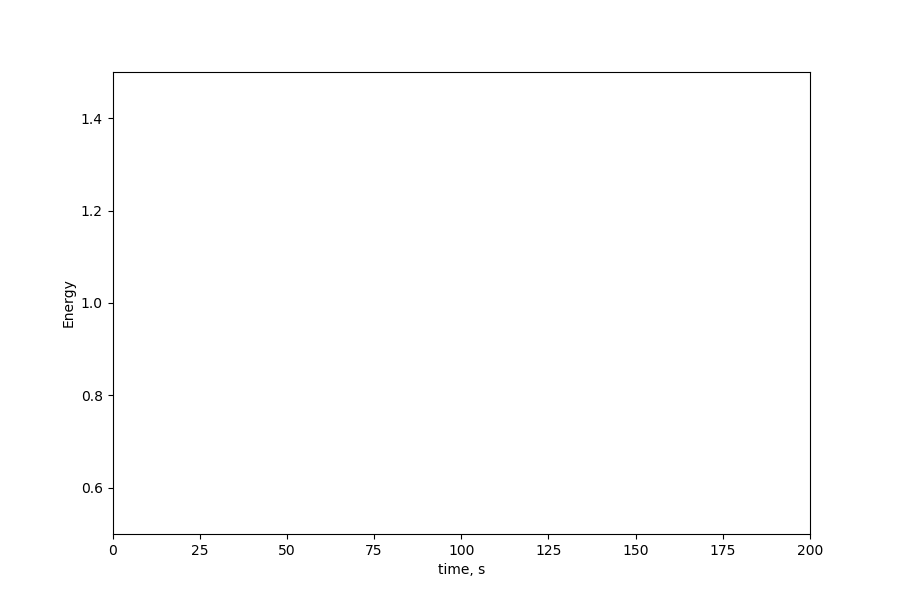

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'data\\res2_64_06_03\\'

In [11]:
name = "res2_64_06_03"
%matplotlib notebook
fig, ax = plt.subplots(1,1)
#print(ax)

plt.ylabel("N(|k|)")
plt.xlabel("|k|")
plt.ylim(10**-7,10**5)
fig.set_size_inches((9,6))
txt = plt.text(1,2*10**5,"123")

fig2,ax2 = plt.subplots(1,1)
plt.ylim(0.5,1.5)
ylim = (0.5,1.5)

plt.xlim(0,nt*dt)
plt.ylabel("Energy")
plt.xlabel("time, s")
fig2.set_size_inches((9,6))

datalen = len(os.listdir("{}\\{}\\".format(datadir,name)))+1

hatmodule0 = hatmodule(res0[1],res0[2],l.dx)

line23 = (np.linspace(1,l.dimx,l.dimx)[:int(l.dimx/3)])**(-2/3)
q = np.argmax(hatmodule0)
line23 =line23/line23[q]*hatmodule0[q]

toplot = [line23]
toplot2 = [([j*savet*dt for j in range(int(nt/savet)+1)], np.zeros(int(nt/savet)+1))]

if not os.path.exists(datadir+"\\"+name): os.makedirs(datadir+"\\"+name)
for i in range(datalen):
    if not os.path.isfile('{}\\{}\\{}_{}.npy'.format(datadir,name,name,i)): 
        break
    try:
        res0 = (np.load('{}\\{}\\{}_{}.npy'.format(datadir,name,name,i)))
        timet = res0[0]
        eng = res0[3]/(64**2)
        forcage = 0#res0[4]
        forcage_coef = 0#res0[5]
        txt.set_text("time passed = {}s; forcage = {:.5f}+-{:.5f}m;".format(timet,forcage,forcage_coef))
        
        if (i%int(datalen/100)==0 and i<datalen/5) or i%int(datalen/3)==0:
            toplot.append(hatmodule(res0[1],res0[2],l.dx))
            pltupdate(fig,ax,toplot)  
            plt.pause(.1)
            
        toplot2[0][1][i]=eng #.append(i)
        if eng<ylim[0]: 
            ylim = (eng/2,ylim[1])
            ax2.set_ylim(ylim)
        if eng>ylim[1]: 
            ylim = (ylim[0],eng*2)
            ax2.set_ylim(ylim)
        pltupdate(fig2,ax2,toplot2,"plot")
        
    except Exception as e:
        print(e)

l.upd(res0[1])
L.upd(res0[2])

<IPython.core.display.Javascript object>


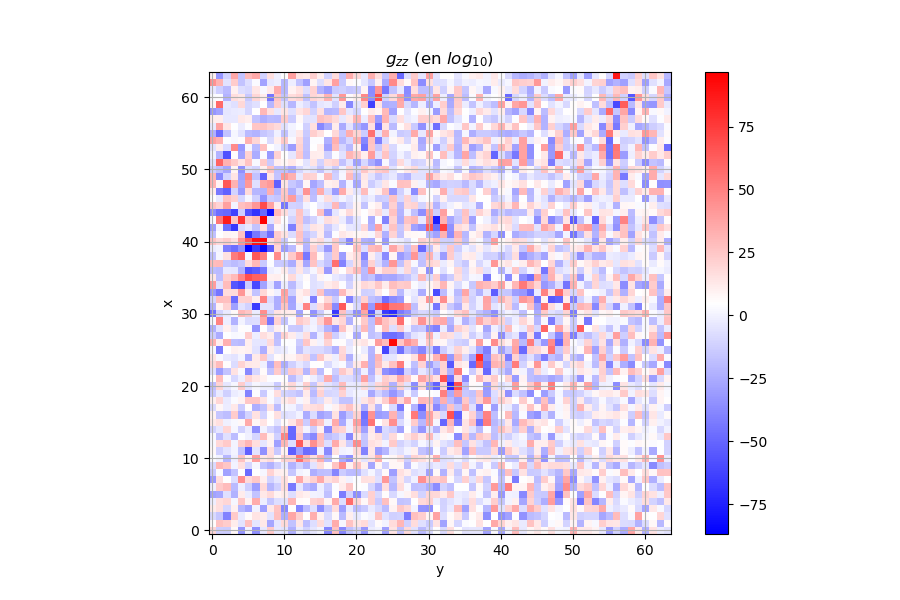

In [18]:
import matplotlib.patches as mpatches
fig3,ax3 = plt.subplots(1,1)
fig3.set_size_inches((9,6))
datt = np.log(np.exp(1-l.d)**2)/np.log(10)
values = np.unique(datt.ravel())

fig.set_size_inches((12,12))
plt.imshow(datt,origin="lower", cmap='bwr', interpolation='nearest')
plt.ylabel("x")
plt.xlabel("y")
plt.title("$g_{zz}$ (en $log_{10}$)")
plt.colorbar()
plt.grid(True)
plt.show()